# Resistively Loaded Antenna Calculator

This notebook will calculate the required resistor values to create a resistively loaded antenna element in the method of [1]. The user must specify the element length, $R_0$, and where resistors should be located along the element, as well as a list of resistor values available. This notebook will calculate the ideal resistor value for each user-specified location and then match it to the closest available resistor value.  A parts list and a diagram of the antenna are generated at the end of the notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Antenna length, $R_0$, and resistor locations along element

In [2]:
h = 25  # Antenna length (m)

R0 = 400  # Balance between impulse response and radiated power
          # Lower R0 worse impulse response, more power
          # Higher R0 better impulse response, less power
          # Normal range is something like 200-600
          # R0 is roughly the observed impedance at resonance (?) need to verify this.

# Resistor locations along element, x=0 is the feed point
# A standard loading would be h/10 spacing for first half of the antenna
# Then h/20 spacing for the next quarter
# Then h/40 spacing for the last quarter

rpos = np.concatenate((
    np.arange(h/20, h/2, h/10),
    np.arange(h/2+h/40, 3*h/4, h/20), 
    np.arange(3*h/4 + h/80, h, h/40),
))

#### Make a plot of resistor locations on the antenna element

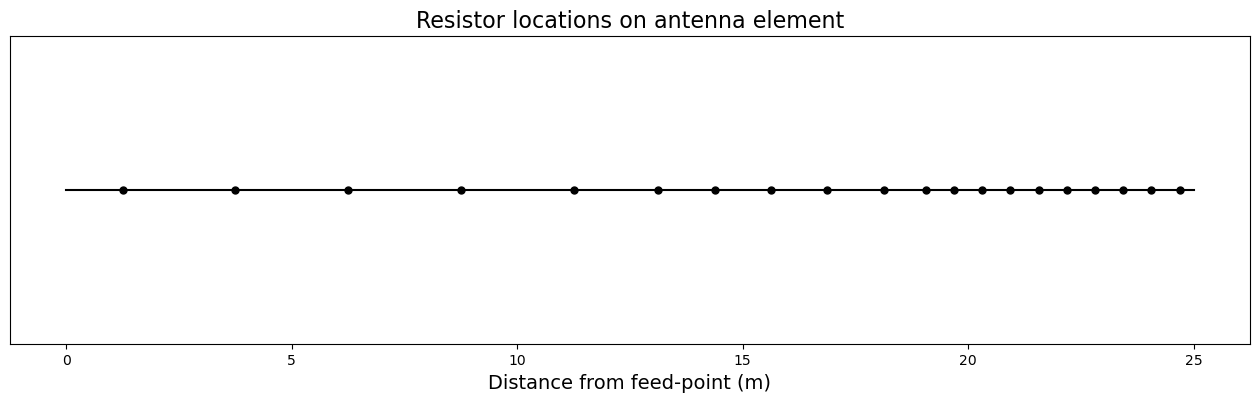

In [3]:
# Plot resistor locations
plt.figure(figsize=(16, 4))

plt.plot([0,h], [1,1],'k') # Draw a line
plt.plot(rpos, np.ones_like(rpos), 'k.', markersize=10) # Dots at resistor locations

plt.gca().get_yaxis().set_visible(False)
plt.xlabel("Distance from feed-point (m)", fontsize=14)
plt.title("Resistor locations on antenna element", fontsize=16)

plt.show()

## Available resistor values
A list of the resistor values available for purchase.

In [4]:
# Ohmite OD series on Digikey Mar 2 2022
cval = [10, 22, 33, 47, 100, 120, 150, 220,
        470, 1e3, 2.2e3, 3.3e3, 4.7e3]

cval = np.array(cval)

## Resistor value calculation
To calculate the value for each resistor we need to integrate the equation below over a segment of the antenna centered on each resistor [1]:
### $$\int_{x_0}^{x_1}\frac{R_0}{h-x}dx = -R_0\cdot ln(\frac{h-x_1}{h-x_0})$$  
where:  
$R_0$ = value chosen by antenna builder (usually 200-800)  
$h$ = length of antenna element  
$x_0$, $x_1$ = antenna segment boundaries, x=0 is the feed point  <br><br>
Calculate segments of antenna approx centered on resistors, integrate over them to find each ideal resistor value

In [5]:
# Calculate antenna segment boundaries centered-ish on resistors
segs = [0]
for i in range(len(rpos)-1):
    segs.append((rpos[i+1]+rpos[i])/2)
segs.append(h-0.01) # Having the end of the antenna as a segment boundary gives infinite resistance

# Calc ideal resistor values
rval = []
for i in range(len(segs)-1):
    rval.append(-R0*np.log((h-segs[i+1])/(h-segs[i])))

In [6]:
np.sum(rval)

3129.6184043424546

## Match ideal resistor values to closest available values

In [7]:
# Quantize to available resistor values
qval = np.zeros_like(rval)
for i,r in enumerate(rval):
    qval[i] = cval[np.argmin(np.abs(r-cval))]

## Generate parts list

In [8]:
# Reduce quantized values to make parts list
plist = {}
for r in qval:
    if(r not in plist.keys()):
        plist[r] = 1
    else:
        plist[r] += 1

# Pretty print parts list
print("qty,ohms")
for r in plist:
    print("%d,%d" % (plist[r], r))

qty,ohms
15,47
1,100
1,120
1,150
1,220
1,2200


## Draw antenna diagram

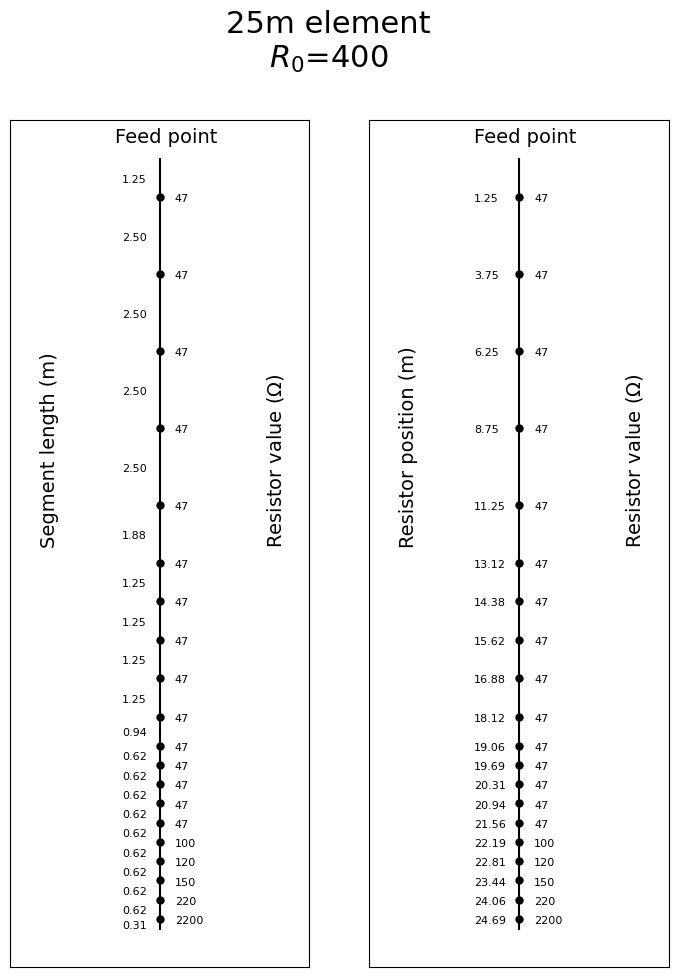

In [9]:
plt.figure(figsize=(8.5, 11)) # fit on printer paper
valfont = 8
plt.suptitle("%dm element\n$R_0$=%d" % (h, R0), fontsize=22)

### Resistor values and segment lengths ###
plt.subplot(1,2,1)
plt.plot([1,1], [0,h],'k') # Draw a line
plt.plot(np.ones_like(rpos), rpos, 'k.', markersize=10) # Dots at resistor locations
plt.xlim((0.95, 1.05))

rpos_ends = np.concatenate(([0], rpos, [h]))
for i,r in enumerate(qval):
    yres = rpos[i]
    plt.annotate("%d" % r, (1.005, yres+h/150), fontsize=valfont)
    
    yseg = (rpos_ends[i] + rpos_ends[i+1])/2
    l = np.diff(rpos_ends)[i]
    plt.annotate("%.2f" % l, (0.9875, yseg+h/150), fontsize=valfont)

plt.annotate("%.2f" % (h-rpos[-1]), (0.9875, h/150 + (rpos[-1]+h)/2), fontsize=valfont)

plt.annotate("Feed point", (.985, -h/50), fontsize=14)
plt.annotate("Segment length (m)", (0.96, h/2), rotation=90, fontsize=14)
plt.annotate("Resistor value ($\\Omega$)", (1.035, h/2), rotation=90, fontsize=14)

#plt.axis("off") # Turn off axes
plt.gca().get_yaxis().set_visible(False)
plt.gca().get_xaxis().set_visible(False)
plt.gca().invert_yaxis() # Feed point at top

### Resistor values and positions ###
plt.subplot(1,2,2)
plt.plot([1,1], [0,h],'k') # Draw a line
plt.plot(np.ones_like(rpos), rpos, 'k.', markersize=10) # Dots at resistor locations
plt.xlim((0.95, 1.05))

for i,r in enumerate(qval):
    x = rpos[i]
    plt.annotate("%d" % r, (1.005, x+h/150), fontsize=valfont)
    plt.annotate("%.2f" % x, (0.985, x+h/150), fontsize=valfont)

plt.annotate("Feed point", (.985, -h/50), fontsize=14)
plt.annotate("Resistor position (m)", (0.96, h/2), rotation=90, fontsize=14)
plt.annotate("Resistor value ($\\Omega$)", (1.035, h/2), rotation=90, fontsize=14)

#plt.axis("off") # Turn off axes
plt.gca().get_yaxis().set_visible(False)
plt.gca().get_xaxis().set_visible(False)
plt.gca().invert_yaxis() # Feed point at top

## Save it? ##
plt.savefig("%dm_%dr0.pdf" % (h, R0), dpi=200)
##    ##    ##

plt.show()

## Output for NEC2 Modeling

In [10]:
fn = "%dm_%dr0.nec" % (h, R0)

with open(fn, mode="w") as fd:
    # Write out comment
    fd.write("CM Resistively loaded dipole with %dm elements and R0 = %d\n" % (h, R0))
    fd.write("CE --- End Comments ---\n")

    # Figure out how many segments to divide antenna into based on resistor spacing
    minl = np.min(l)/2
    nseg = (h*2)/minl

    # Enforce odd segment number so excitation segment is centered
    if(not nseg%2):
        nseg += 1
    seglen = (h*2)/nseg # segment length
    segcent = np.arange(nseg)*seglen + (seglen/2) # segment centers

    # Write out wire
    fd.write("GW     1   %d  %05E  0.00000E+00  0.00000E+00  %05E  0.00000E+00  0.00000E+00  2.00000E-03\n" % (nseg, -h, h))
    fd.write("GE     0     0   0.00000E+00  0.00000E+00  0.00000E+00  0.00000E+00  0.00000E+00  0.00000E+00  0.00000E+00\n")
    fd.write("EX     0     1    %d      0  1.00000E+00  0.00000E+00  0.00000E+00  0.00000E+00  0.00000E+00  0.00000E+00\n" % (nseg//2  + 1))

    # Write out loads
    for i, r in enumerate(qval):
        for pos in [h+rpos[i], h-rpos[i]]:
            # Find closest segment center to resistor position, assign to that and write out
            segid = np.argmin(np.abs(segcent-pos))+1
            fd.write("LD     0     1   %d   %d  %05E  0.00000E+00  0.00000E+00  0.00000E+00  0.00000E+00  0.00000E+00\n" % (segid, segid, r))
            
    # Frequency sweep
    fd.write("FR     0   251     0     0  0.00000E+00  1.00000E-01  2.50000E+01  0.00000E+00  0.00000E+00  0.00000E+00\n")

    # Radiation pattern
    fd.write("RP     0    90    90      0  0.00000E+00  0.00000E+00  4.00000E+00  4.00000E+00  0.00000E+00  0.00000E+00\n")
        
    # End
    fd.write("EN     0     0     0      0  0.00000E+00  0.00000E+00  0.00000E+00  0.00000E+00  0.00000E+00  0.00000E+00\n")


## Reference
[1] Jones, F., Narod, B., & Clarke, G. (1989). Design and Operation of a Portable, Digital Impulse Radar. Journal of Glaciology, 35(119), 143-148. doi:10.3189/002214389793701383  